<a href="https://colab.research.google.com/github/Rahul-Tclb/Eluvio_DS_Challenge/blob/main/Eluvio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Sentiment of News Titles using Logistic Regression Model



### Importing Data Manipulation , Numerical and Visulization and Dependencies  

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import nltk  
nltk.download('stopwords')
import re  
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
# import warnings
# warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading Dataset from Drive Link

In [2]:
Dataset = pd.read_csv("./drive/MyDrive/csv/Eluvio_DS_Challenge.csv")

### Copy Entire Dataset to local variable called df

In [3]:
df = Dataset.copy()

### Overview of Unstructered Data

In [4]:
df.head(10)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
5,1201287889,2008-01-25,15,0,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,worldnews
6,1201289438,2008-01-25,5,0,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,worldnews
7,1201536662,2008-01-28,0,0,The U.N. Mismanagement Program,False,Moldavite,worldnews
8,1201558396,2008-01-28,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,Moldavite,worldnews
9,1201635869,2008-01-29,3,0,US plans for missile shields in Polish town me...,False,JoeyRamone63,worldnews


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


### Subsetting two Columns for which i will be working  

In [6]:
columns = ['up_votes', 'title']
df1 = df[columns]

### Performing Feature Engineering and Derived a new Column called Label

*   I considered All the titles having less than or equal tp  4 upvotes as negative labels
*   I considered All the titles having more than 4 upvotes as positive labels



In [7]:
df1['Label']  = df1['up_votes'].apply(lambda x: 0 if x <= 4 else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Reindexing the Columns and View first and last few records

In [8]:
df1 = df1.reindex(columns = ['title' , 'up_votes' , 'Label'] )

In [9]:
df1.head(5)

,title,up_votes,Label
0,Scores killed in Pakistan clashes,3,0
1,Japan resumes refuelling mission,2,0
2,US presses Egypt on Gaza border,3,0
3,Jump-start economy: Give health care to all,1,0
4,Council of Europe bashes EU&UN terror blacklist,4,0


In [10]:
df1.tail()

,title,up_votes,Label
509231,Heil Trump : Donald Trump s alt-right white...,5,1
509232,There are people speculating that this could b...,1,0
509233,Professor receives Arab Researchers Award,1,0
509234,Nigel Farage attacks response to Trump ambassa...,1,0
509235,Palestinian wielding knife shot dead in West B...,1,0


### creating two new Dataframes containing Positive and Negative titles 

*   The positive_title consists of all positive labels with respective news titles
*   The negative_title consists of all negative labels with respective news titles



In [11]:
positive_title = df1[df1['Label'] == 1].reset_index().drop('index' , axis = 1)
negative_title = df1[df1['Label'] == 0].reset_index().drop('index' , axis = 1)

### plotting a Pie chart to see the proportion of Positive and Negative labels

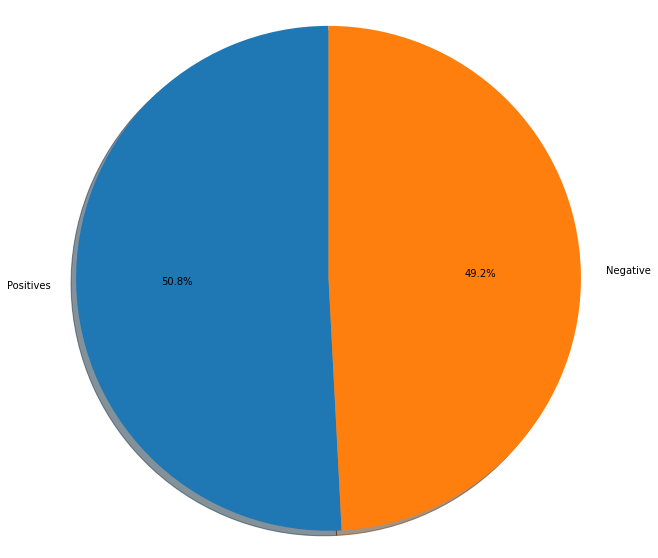

In [12]:
fig = plt.figure(figsize=(10, 10))
labels = 'Positives', 'Negative'
sizes = [positive_title.shape[0] ,  negative_title.shape[0]] 
plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal') 
plt.show()

### Pre-Processing the Un-Structured Data 

#### for the sake of undetstanding I am going to take one specific title and lets print the content and what see what are the vocabalary inside it

In [13]:
title0 = positive_title['title'][0]
title0

'Hay presto! Farmer unveils the  illegal  mock-Tudor castle he tried to hide behind 40ft hay bales'

#### Removing styles , hyperlinks , hashtags from all the titles and  sure to 

*   unfortunately for the specific example we do not have them but we will makeremove from all of the titles

*   Lets print after removing all of those and see how it looks like





In [14]:

# remove old style retweet text "RT"
title0 = re.sub(r'^RT[\s]+', '', title0)

# remove hyperlinks
title0 = re.sub(r'https?:\/\/.*[\r\n]*', '', title0)

# remove hashtags
# only removing the hash # sign from the word
title0 = re.sub(r'#', '', title0)

print(title0)

Hay presto! Farmer unveils the  illegal  mock-Tudor castle he tried to hide behind 40ft hay bales


#### Tokenization is the process of splitting a string into a list of tokens


*   Using TweetTokenizer I am going to split the titles into a list of string tokens
*   Lets apply TweetTokenizer to the above output and see how the Tokenized string looks like 





In [15]:
title1 = title0

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,  reduce_len=True)       # creating am object from class Tweet
title_tokens = tokenizer.tokenize(title1)                                                   # toekenizing for the title1  

print('Tokenized string:')
print(title_tokens)

Tokenized string:
['hay', 'presto', '!', 'farmer', 'unveils', 'the', 'illegal', 'mock-tudor', 'castle', 'he', 'tried', 'to', 'hide', 'behind', '40ft', 'hay', 'bales']


#### Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document.

*  Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.

In [16]:
stopwords_english = stopwords.words('english')                                              # creating an Object of Stopwords_engilish from NLTK         

title_clean = []                                                                            # initilizing an Empty list to append the processed words

for word in title_tokens:                                                                   # using for Loop and running it through every word in tokenized string and 
    if (word not in stopwords_english and                                                   # removing the stopwords and then    
        word not in string.punctuation):                                                    # removeing punctuation
        title_clean.append(word)

print('removed stop words and punctuation:')
print(title_clean)                                                                           

removed stop words and punctuation:
['hay', 'presto', 'farmer', 'unveils', 'illegal', 'mock-tudor', 'castle', 'tried', 'hide', 'behind', '40ft', 'hay', 'bales']


##### Let’s first understand stemming:

* Stemming is a text normalization technique that cuts off the end or beginning of a word by taking into account a list of common prefixes or suffixes that could be found in that word
* It is a rudimentary rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word

In [17]:
stemmer = PorterStemmer()                                                                  # Instantiate stemming class

title_stem = []                                                                            # Create an empty list to store the stems

for word in title_clean:                                                                   # Running a for loop after removing stopwords into title_clean and
    stem_word = stemmer.stem(word)                                                         # stemming word i.e taking back to it root form or base form and
    title_stem.append(stem_word)                                                           # append to the list title_stem

print('stemmed words:')
print(title_stem)

stemmed words:
['hay', 'presto', 'farmer', 'unveil', 'illeg', 'mock-tudor', 'castl', 'tri', 'hide', 'behind', '40ft', 'hay', 'bale']


### By combining All the Above Pre-Processing steps ans Making Everything Included in one function called Process_tweet(title)

In [18]:
def process_tweet(title):
  """
  Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
  stemmer = PorterStemmer()                                                           # Instantiate stemming class
  stopwords_english = stopwords.words('english')                                      # Instantiate Stopwords class
  title = re.sub(r'\$\w*', '', title)                                                 # remove stock market tickers like $GE
  title = re.sub(r'^RT[\s]+', '', title)                                              # remove old style retweet text "RT"
  title = re.sub(r'https?:\/\/.*[\r\n]*', '', title)                                  # remove hyperlinks
  title = re.sub(r'#', '', title)                                                     # remove hashtags only hashtag "#"
  tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)  # Instantiate TweetTokenizer class
  Title_tokens = tokenizer.tokenize(title)                                            # Tokenizing Every titles

  Title_clean = []                                                                    # creating an Empty list
  for word in Title_tokens:                                                           # using for loop runnig through the tokenizeds title
      if (word not in stopwords_english and                                           # Remove stop words
          word not in string.punctuation):                                            # Remove punctuations
          stem_word = stemmer.stem(word)                                              # Bring it to base form usign stemming 
          Title_clean.append(stem_word)                                               # Append it to the List called Title_clean

  return Title_clean                                                                  # Return the Output


#### Lets try one title to see the cleaned Data

In [19]:
Title_clean = process_tweet(positive_title['title'][0])
print(Title_clean , end = "") 

['hay', 'presto', 'farmer', 'unveil', 'illeg', 'mock-tudor', 'castl', 'tri', 'hide', 'behind', '40ft', 'hay', 'bale']

In [20]:
def build_freqs(titles, ys):
   """
   Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency"""

  # Convert np array to list since zip needs an iterable.
  # The squeeze is necessary or the list ends up with one element.

   yslist = np.squeeze(ys).tolist()

  # Start with an empty dictionary and populate it by looping over all titles
  # and over all processed words in each title

   freqs = {}                                                                            # initilize and Empyty Dictionary
   for y, title in zip(yslist, titles):                                                  # loop the label and titles 
       for word in process_tweet(title):                                                 # processing each title to create a tidy format data
           pair = (word, y)                                                              # pairing the word and respective label
           if pair in freqs:                                                             # Applying the condition for the pairs in freqs
               freqs[pair] += 1                                                          # if pair is present the add 1 and move forward
           else:                                                                         
               freqs[pair] = 1                                                           # else pair is one
   return freqs



#### Creating train and test data 

#### Extracting only the titles from Positive and Negative titles dataframes

In [21]:
all_positive_titles = list(positive_title['title'])
all_negative_titles = list(negative_title['title'])

#### Subset the titles to 250398 records to Make balance data for both classes

In [22]:
title_length = 250398

In [23]:
all_positive_titles = all_positive_titles[0:title_length]
all_negative_titles = all_negative_titles[0:title_length]

#### Subset the labels to 250398 records to Make balance data for both classes

In [24]:
all_positive_labels = positive_title['Label'][0:title_length]
all_negative_labels = positive_title['Label'][0:title_length]

#### set training size 

In [25]:
train_size = math.ceil(len(all_positive_titles) * 0.8 )

##### split Train and Test data for Positve and Negative labels

In [26]:
train_pos = all_positive_titles[0 : train_size]
test_pos  = all_positive_titles[train_size:]

train_neg = all_negative_titles[0:train_size]
test_neg  = all_negative_titles[train_size:]

In [27]:
train_pos_lab = all_positive_labels[0 : train_size]
test_pos_lab  = all_positive_labels[train_size:]

train_neg_lab = all_negative_labels[0:train_size]
test_neg_lab  = all_negative_labels[train_size:]

#### create final Train and Test data

In [28]:
train_x  = train_pos + train_neg
test_x  = test_pos + test_neg

In [29]:
train_y = np.append(train_pos_lab , train_neg_lab).reshape(-1,1)
test_y  = np.append(test_pos_lab , test_neg_lab).reshape(-1,1)

### A dictionary mapping each (word, sentiment) pair to its frequency

In [30]:
freqs  = build_freqs( train_x , train_y)

In [31]:
freqs

{('hay', 1): 23,
 ('presto', 1): 1,
 ('farmer', 1): 862,
 ('unveil', 1): 777,
 ('illeg', 1): 2182,
 ('mock-tudor', 1): 1,
 ('castl', 1): 67,
 ('tri', 1): 3468,
 ('hide', 1): 481,
 ('behind', 1): 1711,
 ('40ft', 1): 2,
 ('bale', 1): 16,
 ('strike', 1): 5970,
 ('protest', 1): 14249,
 ('gridlock', 1): 24,
 ('poland-ukrain', 1): 1,
 ('border', 1): 4446,
 ('top', 1): 3954,
 ('us', 1): 18423,
 ('envoy', 1): 854,
 ('violenc', 1): 3515,
 ('kenya', 1): 1123,
 ('ethnic', 1): 652,
 ('cleans', 1): 175,
 ('mass', 1): 2183,
 ('evacu', 1): 1078,
 ('continu', 1): 2694,
 ('secret', 1): 2646,
 ('cia', 1): 1262,
 ('flight', 1): 2145,
 ('greenland', 1): 131,
 ('report', 1): 11240,
 ('denmark', 1): 459,
 ('piss', 1): 53,
 ('investig', 1): 3603,
 ('children', 1): 4278,
 ('torch', 1): 383,
 ('kenyan', 1): 545,
 ('school', 1): 2991,
 ('teacher', 1): 751,
 ('attack', 1): 15915,
 ('russia', 1): 13664,
 ('say', 1): 25325,
 ('iranian', 1): 3401,
 ('missil', 1): 2926,
 ('test', 1): 2505,
 ('week', 1): 3542,
 ('rai

### As it was a logistic regression classifier creating few functions 


*   Sigmoid : Return the probability in between 0 and 1 as a Biniary classifier
*   Gradient Descent :
    * Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. 
    * The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. Conversely, stepping in the direction of the gradient will lead to a local maximum of that function 
    * the procedure is then known as gradient ascent.



In [32]:
def sigmoid(z):                                                               
  h = np.divide(1 , np.add(1 , np.exp(-z)))
  return h

In [33]:
def gradient_descent(x , y , theta , alpha , num_iters , epsilon):
  m = len(x)
  for i in range(0 , num_iters):
    z = np.dot(x , theta)
    h = np.divide( 1 , np.add( 1 , np.exp(-z)))
    J = (-1/m) * (np.dot(y.T , np.log(h+epsilon)) + np.dot((1-y).T , np.log((1-h)+epsilon)))
    theta = np.subtract(theta , np.multiply(np.divide(alpha , m) , np.dot(x.T , np.subtract(h,y))))

  J = float(J)
  return J , theta 

### Extracting a feature vector of dimension of (1,3) using the function extract features

In [34]:
def extract_features(title , freqs):
  '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''

  word_1 = process_tweet(title)                                                            # process_tweet tokenizes, stems, and removes stopwords
  x = np.zeros((1 , 3))                                                                    # 3 elements in the form of a 1 x 3 vector [ bias , positive_label , negative_label]
  x[0,0] = 1                                                                               # bias is set to 1
       
  for word in word_1:                                                                      # runnig for loop through the word
    x[0,1] += freqs.get((word , 1.0 ) , 0 )                                                # increment the word count for the positive label 1
    x[0,2] += freqs.get((word , 0.0)  , 0)                                                 # increment the word count for the negative label 0

  assert(x.shape == (1,3))
  return x


### Training the Logistic Regression  Model

In [35]:
X = np.zeros((len(train_x) , 3))                                                           # collect the features 'x' and stack them into a matrix 'X'


for i in range(len(train_x)):
  X[i,:] = extract_features(train_x[i] , freqs)

Y = train_y                                                                                # training labels corresponding to X

### Apply Gradient Descent Algorthim 

In [36]:
J, theta = gradient_descent(X, Y, np.zeros((3, 1)), 0.1, 500 , 0.000001)                     # Training the model using X , Y and theta and Hyper Parameters

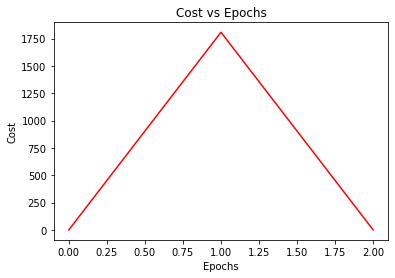

In [37]:
plt.plot(theta , color = 'r')
plt.xlabel("Epochs")
plt.ylabel('Cost')
plt.title("Cost vs Epochs")
plt.show()

In [38]:
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.00001401.
The resulting vector of weights is [0.0505464, 1807.69728608, 0.0]


### Testing the Model 

In [39]:
def predict_title(title , freqs , theta):
  '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
  x = extract_features(title , freqs)                                                           # extract the features of the tweet and store it into x
  y_pred = np.divide( 1 , np.add( 1 , np.exp(-np.dot(x , theta))))                              # make the prediction using x and theta
  
  return y_pred            

In [40]:
def test_logistic_regression(test_x , test_y , freqs , theta ):
  """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
  """
  y_hat = []                                                                                   # the list for storing predictions
  for title in test_x:
    y_pred = predict_title(title , freqs , theta)                                              # get the label prediction for the tweet

    if y_pred > 0.5:
      y_hat.append(1)                                                                          # append 1.0 to the list
    else:
      y_hat.append(0)                                                                          # append 0 to the list
  
                                                                                               # With the above implementation, y_hat is a list, but test_y is (m,1) array
                                                                                               # convert both to one-dimensional arrays in order to compare them using the '==' operator

  accuracy = (y_hat ==  np.squeeze(test_y)).sum()/len(test_y)

  return accuracy 

In [41]:
accuracy = test_logistic_regression(test_x, test_y, freqs, theta)


In [42]:
print(f"Logistic regression model's accuracy = {accuracy:.4f}")

Logistic regression model's accuracy = 1.0000


### Predict unknow titles

In [43]:
# Feel free to change the tweet below
my_title = "I Love Captain America"
print(process_tweet(my_title))
y_hat = predict_title(my_title, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['love', 'captain', 'america']
[[1.]]
Positive sentiment
